In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from google.cloud import storage
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Function to get data

def get_stock_data_from_gcp(nrows=10000, local=False, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from google cloud bucket"""
    # Add Client() here
    client = storage.Client()
    if local:
        path = "data/data_data_10Mill.csv"
    else:
        path = "gs://stock-news-pred-bucket/amazon_stock_price.csv"
    df = pd.read_csv(path)#add nrows after if you want to select a specific number of row
    return df

In [3]:
df = get_stock_data_from_gcp()

In [4]:
df

,date,AMZN
0,2021-11-22,3572.57
1,2021-11-19,3676.57
2,2021-11-18,3696.06
3,2021-11-17,3549.00
4,2021-11-16,3540.70
...,...,...
5547,1999-11-05,64.94
5548,1999-11-04,63.06
5549,1999-11-03,65.81
5550,1999-11-02,66.44


In [5]:
X = df[['AMZN']]

In [6]:
X

,AMZN
0,3572.57
1,3676.57
2,3696.06
3,3549.00
4,3540.70
...,...
5547,64.94
5548,63.06
5549,65.81
5550,66.44


In [7]:
# Function to scale data

def scale_stock_data(df, ticker):
    X = df[[ticker]]
    sc = MinMaxScaler().fit(X)
    X_sc = sc.fit_transform(X)
    return sc, X_sc

In [8]:
# Function to split scaled data

def split_stock_data(X_sc, train_size):
    index = round(train_size*X_sc.shape[0])
    X_sc_train = X_sc[:index]
    X_sc_test = X_sc[index:]
    return X_sc_train, X_sc_test

In [9]:
# Function to reshape scaled train data

def reshape_train_data(X_sc_train, obs):
    X_train = []
    y_train = []
    for i in range(obs, X_sc_train.shape[0]):
        X_train.append(X_sc_train[i-obs:i, 0])
        y_train.append(X_sc_train[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    return X_train, y_train

In [10]:
# Function to reshape scaled test data

def reshape_test_data(X_sc_test, obs):
    X_test = []
    y_test = []
    for i in range(obs, X_sc_test.shape[0]):
        X_test.append(X_sc_test[i-obs:i, 0])
        y_test.append(X_sc_test[i, 0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test, y_test

In [11]:
# Function to inverse transform

def inverse_transformer(y):
    y = np.c_[y, np.ones(len(y))]
    y = scaler.inverse_transform(y)
    y = y[:,0]
    return y

In [12]:
# Function to build the lstm model

def lstm_model():
    model = Sequential()
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return model

In [13]:
# Function to train the model

def train_model(X_train, y_train):   
    model = lstm_model()
    es = EarlyStopping(patience=30, restore_best_weights=True)
    model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[es], verbose=1)
    return model

In [16]:
# Function to predict results

def predict_model(ticker):
    sc, X_sc = scale_stock_data(df, ticker) 
    X_sc_train, X_sc_test = split_stock_data(X_sc, 0.8)
    X_train, y_train = reshape_train_data(X_sc_train, 30)
    X_test, y_test = reshape_test_data(X_sc_test, 30)
    #sc = MinMaxScaler().fit(X)
    model = train_model(X_train, y_train)
    predicted_stock_price = model.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    return predicted_stock_price

In [17]:
prediction = predict_model('AMZN')

Epoch 1/100
111/111 [==============================] - 11s 47ms/step - loss: 0.0073 - val_loss: 9.8571e-06
Epoch 2/100
111/111 [==============================] - 4s 37ms/step - loss: 0.0020 - val_loss: 2.6195e-06
Epoch 3/100
111/111 [==============================] - 4s 38ms/step - loss: 0.0015 - val_loss: 1.1670e-06
Epoch 4/100
111/111 [==============================] - 4s 37ms/step - loss: 0.0017 - val_loss: 4.9229e-06
Epoch 5/100
111/111 [==============================] - 4s 37ms/step - loss: 0.0016 - val_loss: 4.1944e-06
Epoch 6/100
111/111 [==============================] - 4s 37ms/step - loss: 0.0013 - val_loss: 1.2166e-04
Epoch 7/100
111/111 [==============================] - 4s 37ms/step - loss: 0.0013 - val_loss: 5.5029e-05
Epoch 8/100
111/111 [==============================] - 4s 37ms/step - loss: 0.0016 - val_loss: 6.3076e-06
Epoch 9/100
111/111 [==============================] - 4s 37ms/step - loss: 0.0014 - val_loss: 3.0521e-05
Epoch 10/100
111/111 [=======================

In [18]:
prediction

array([[40.326454],
       [40.439148],
       [40.59658 ],
       ...,
       [72.217224],
       [71.01276 ],
       [69.77436 ]], dtype=float32)

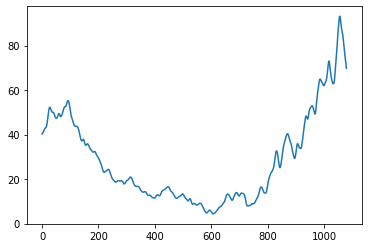

In [20]:
plt.plot(prediction);

In [23]:
def model_training_for_joblib(ticker):
    sc, X_sc = scale_stock_data(df, ticker) 
    X_sc_train, X_sc_test = split_stock_data(X_sc, 0.8)
    X_train, y_train = reshape_train_data(X_sc_train, 30)
    X_test, y_test = reshape_test_data(X_sc_test, 30)
    model = train_model(X_train, y_train)
    return model

In [24]:
model = model_training_for_joblib('AMZN')

Epoch 1/100
111/111 [==============================] - 11s 54ms/step - loss: 0.0069 - val_loss: 1.4633e-05
Epoch 2/100
111/111 [==============================] - 4s 38ms/step - loss: 0.0019 - val_loss: 4.6971e-06
Epoch 3/100
111/111 [==============================] - 4s 37ms/step - loss: 0.0017 - val_loss: 8.3165e-05
Epoch 4/100
111/111 [==============================] - 4s 37ms/step - loss: 0.0018 - val_loss: 4.8635e-05
Epoch 5/100
111/111 [==============================] - 4s 40ms/step - loss: 0.0016 - val_loss: 1.6751e-04
Epoch 6/100
111/111 [==============================] - 6s 53ms/step - loss: 0.0013 - val_loss: 2.3006e-06
Epoch 7/100
111/111 [==============================] - 4s 38ms/step - loss: 0.0012 - val_loss: 1.0823e-05
Epoch 8/100
111/111 [==============================] - 5s 42ms/step - loss: 0.0012 - val_loss: 2.4520e-04
Epoch 9/100
111/111 [==============================] - 4s 39ms/step - loss: 0.0013 - val_loss: 1.2548e-04
Epoch 10/100
111/111 [=======================

111/111 [==============================] - 5s 45ms/step - loss: 7.3814e-04 - val_loss: 4.3744e-05
Epoch 76/100
111/111 [==============================] - 5s 43ms/step - loss: 6.0666e-04 - val_loss: 1.1978e-05


In [25]:
from keras.models import load_model

model.save('lstm_model_stock_price.h5')

In [27]:
model_test = load_model('lstm_model_stock_price.h5')

In [28]:
sc, X_sc = scale_stock_data(df, 'AMZN')

In [29]:
X_sc_train, X_sc_test = split_stock_data(X_sc, 0.8)

In [30]:
X_train, y_train = reshape_train_data(X_sc_train, 30)

In [31]:
X_test, y_test = reshape_test_data(X_sc_test, 30)

In [32]:
y_pred = model_test.predict(X_test)

In [33]:
y_pred

array([[0.00985712],
       [0.00989665],
       [0.0099518 ],
       ...,
       [0.01838863],
       [0.01804392],
       [0.01769026]], dtype=float32)